# Working ipynb for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

## Model Building

Imports. Clean up later

In [2]:
from __future__ import print_function
from helpful_util import *
from heaton_utils import *

#import seaborn as sns
#import pandas_profiling
#from pylab import rcParams
#import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy

import os
import sys
import glob
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy
from keras.utils import multi_gpu_model

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import multilayer_perceptron
import xgboost
import pandas_profiling
from pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 7,7  #Adjust plot size

device_lib.list_local_devices(
)  #See available devices. If Running a Keras model, session to GPU

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 647360743561589188, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6590074061
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3628298667062804377
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4869333295175662036
 physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [163]:
def save_obj(obj, name):
    import pickle
    with open('obj/lendingclub_v2/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    import pickle
    with open('obj/lendingclub_v2/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [96]:
df = pd.read_csv('loan.csv', low_memory=False)
df = df.dropna(axis=1, thresh=int(0.80 * len(df)))
df = df.dropna(thresh=0)

In [98]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 0
    else:
        return 1
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

df_good = df[df['loan_condition'] == 1][:10000] #DownSample
df_bad = df[df['loan_condition'] ==0][:10000]

In [154]:
df = pd.concat([df_good,df_bad])
cat_feats = ['grade', 'sub_grade',  'home_ownership',
'title', 'loan_condition'
]

df_contin = df.loc[:, df.dtypes == np.float64]
df_cat = df.loc[:, df.dtypes != np.float64]
df_cat = df_cat[cat_feats]
df1 = pd.concat([df_contin,df_cat])


cols = df1.columns.tolist()
column_to_move = "loan_condition"
new_position = 66

cols.insert(new_position, cols.pop(cols.index(column_to_move)))
df1 = df[cols]
df1 = df1.fillna(0)

In [156]:
#g = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")

#X_train, X_test, y_train, y_test = split_data(
#    df=df,
#    keras=False,  #Use binary vector for response, no OHE
#    testSize=0.3,
#    randomState=123)


#Cleaning data per the Lime docs. The way I did it initially gave nonsensical results because of the category mapping
#We need to first encode the cat feaures and then one hot encode them using sklearn.preprocessing


feature_names = df.columns


data = np.array(df1)
y = data[:,-1] #response var
le= sklearn.preprocessing.LabelEncoder() #instantiate label encoder
le.fit(y) #fit label encoder to response
y = le.transform(y) #encode response
class_names = le.classes_ #get class names of response
data = data[:,:-1] #Get all Independent Vars

categorical_features = []
counter = 0
for i in df1.dtypes:
    if i == object:
        categorical_features.append(counter)
    counter +=1
        
        
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder() #instantiate label encoder
    le.fit(data[:, feature]) #fit label encoder to categorical features
    data[:, feature] = le.transform(data[:, feature]) #transform categorical features
    categorical_names[feature] = le.classes_ #get categorical feature class names and append to dict

X = data.astype(float) 
encoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_features) #instantiate OHE

np.random.seed(1)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.80, stratify = y) #split data

encoder.fit(data) #OHE Categorical Columns
encoded_train = encoder.transform(X_train) #Encode Training Set
encoded_test = encoder.transform(X_test)
y_train_keras = y_train



In [157]:
encoder.fit(data) #OHE Categorical Columns
encoded_train = encoder.transform(X_train) #Encode Training Set
encoded_test = encoder.transform(X_test)
y_train_keras = y_train

In [164]:
save_obj(X_train, 'X_train')
save_obj(X_test, 'X_test')
save_obj(y_train, 'y_train')
save_obj(y_test, 'y_test')
save_obj(encoded_train, 'encoded_train')
save_obj(encoded_test, 'encoded_test')
save_obj(categorical_names, 'categorical_names')
save_obj(encoder, 'encoder')
save_obj(df1, 'data')

X_train = load_obj('X_train')
X_test = load_obj('X_test')
y_train = load_obj('y_train')
y_test = load_obj('y_test')

encoded_train = load_obj('encoded_train')
encoded_test = load_obj('encoded_test')
categorical_names = load_obj('categorical_names')
data = load_obj('data')
encoder = load_obj('encoder')

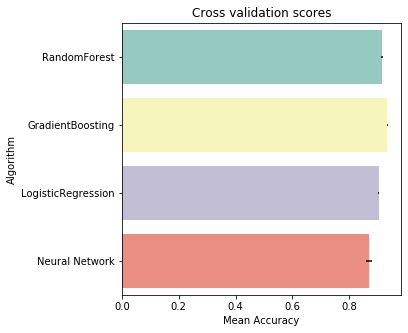

In [159]:
rcParams['figure.figsize'] = 5, 5  #Adjust plot size

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=3)

#Run Kfold CrossVal on base classifiers

random_state = 1
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier,
                        encoded_train,
                        y=y_train,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=6))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":
    cv_means,
    "CrossValerrors":
    cv_std,
    "Algorithm": ["RandomForest", "GradientBoosting", "LogisticRegression", "Neural Network"]
})

g = sns.barplot("CrossValMeans",
                "Algorithm",
                data=cv_res,
                palette="Set3",
                orient="h",
                **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [160]:
#Grid Search parameter space.
#Cut back on this due to experimentation and compute time

# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "n_estimators": [150,250]
    #"max_features": [1, 2, 3, 4, 5, 6, 7, 8,9,10],
    #"bootstrap": [False],
}

gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsRFC.fit(encoded_train, y_train)

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [1000,2000]
    #'learning_rate': [.001],
    #'max_depth': [4, 8, 12],
}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsGBC.fit(encoded_train, y_train)

#Sklearn Logit Regression Tuning
LR = LogisticRegression()
LR_param_grid = {'penalty': ['l1', 'l2']}

gsLR = GridSearchCV(LR,
                    param_grid=LR_param_grid,
                    cv=kfold,
                    scoring="accuracy",
                    n_jobs=6,
                    verbose=1)
gsLR.fit(encoded_train, y_train)

ANN = MLPClassifier()

## Search grid for optimal parameters
ann_param_grid = {
    "hidden_layer_sizes": [150],
    "activation": ['relu'],
    "solver": ['adam'],
    "learning_rate": ['adaptive'],
    

}

gsAnn = GridSearchCV(ANN,
                     param_grid=ann_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsAnn.fit(encoded_train, y_train)

# Best score
print("\033[1mPrinting Best Cross Validation Accuracy.... \033[0m")
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ * 100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ * 100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ * 100))
print("MLP Best Score: {0:.2f} %".format(gsAnn.best_score_ * 100))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   12.4s remaining:   24.9s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   19.8s finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.4min remaining:  2.8min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.6min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    5.5s remaining:   11.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   35.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:   25.0s finished


Printing Best Cross Validation Accuracy.... 
RF Best Score: 93.44 %
GBC Best Score: 95.00 %
Logit Best Score: 91.01 %
MLP Best Score: 84.82 %


C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [165]:
#Visualizing hyper params of best models + dumping best models to pkl

print("Model Hyper-Parameters:\n")
print(gsRFC.best_estimator_)
print(gsGBC.best_estimator_)
print(gsLR.best_estimator_)
print(gsAnn.best_estimator_)
import pickle
from sklearn.externals import joblib

print("Serializing Best Models\n")
rf_file = "models\\LendingClub_v2\\random_forest.pkl"
joblib.dump(gsRFC.best_estimator_, rf_file)

gbc_file = "models\\LendingClub_v2\\GBC.pkl"
joblib.dump(gsGBC.best_estimator_, gbc_file)

logit_file = "models\\LendingClub_v2\\Logit.pkl"
joblib.dump(gsLR.best_estimator_, logit_file)

ann_file = "models\\LendingClub_v2\\SklearnNeuralNet.pkl"
joblib.dump(gsAnn.best_estimator_, ann_file)
#Note - Outliers were removed, but no features were scaled / normalized.

Model Hyper-Parameters:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, pres

['models\\LendingClub_v2\\SklearnNeuralNet.pkl']

In [166]:
from sklearn.externals import joblib
rcParams['figure.figsize'] = 3, 3  #Adjust plot size
kfold = StratifiedKFold(n_splits=5)
rf_file = "models\\LendingClub_v2\\random_forest.pkl"
gbc_file = "models\\LendingClub_v2\\GBC.pkl"
logit_file = "models\\LendingClub_v2\\Logit.pkl"
ann_file = "models\\LendingClub_v2\\SklearnNeuralNet.pkl"
#fetch saved models
rfc = joblib.load(rf_file)
gbc = joblib.load(gbc_file)
logit = joblib.load(logit_file)
ann = joblib.load(ann_file)

Printing Test Accuracy.... 
Random Forest: 93.80 %
Gradient Boosting: 95.65 %
Logistic Regression: 91.45 %
Neural Net: 86.40 % 
 

 Random Forest Classification Report...
 
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      2000
           1       0.90      0.98      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



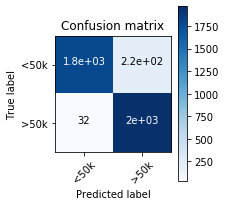

 Gradient Boosting Classification Report...
 
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2000
           1       0.93      0.98      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



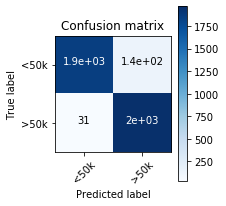

 Logistic Regression Classification Report...
 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2000
           1       0.86      0.98      0.92      2000

    accuracy                           0.91      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.91      0.91      4000



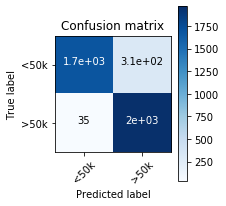

 Neural Network Classification Report...
 
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2000
           1       0.80      0.98      0.88      2000

    accuracy                           0.86      4000
   macro avg       0.88      0.86      0.86      4000
weighted avg       0.88      0.86      0.86      4000



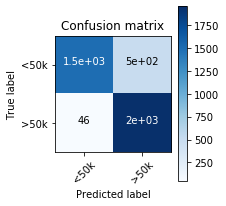

In [167]:
#Some classification Reports and Confusion Matrices
from sklearn.metrics import confusion_matrix, classification_report


class_names = ['<50k', '>50k']

rf_best_score = sklearn.metrics.accuracy_score(y_test, rfc.predict(encoder.transform(X_test)))
gbc_best_score = sklearn.metrics.accuracy_score(y_test, gbc.predict(encoder.transform(X_test)))
lr_best_score = sklearn.metrics.accuracy_score(y_test, logit.predict(encoder.transform(X_test)))
nn_best_score = sklearn.metrics.accuracy_score(y_test, ann.predict(encoder.transform(X_test)))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} %".format(lr_best_score * 100))
print("Neural Net: {0:.2f} % \n \n".format(nn_best_score * 100))


rcParams['figure.figsize'] = 3, 3  #Adjust plot size

print("\033[1m Random Forest Classification Report...\n \033[0m")
print(classification_report(y_test, rfc.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, rfc.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Gradient Boosting Classification Report...\n \033[0m")
print(classification_report(y_test, gbc.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, gbc.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Logistic Regression Classification Report...\n \033[0m")
print(classification_report(y_test, logit.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, logit.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Neural Network Classification Report...\n \033[0m")
print(classification_report(y_test, ann.predict(encoder.transform(X_test))))
cm = confusion_matrix(y_test, ann.predict(encoder.transform(X_test)))
plot_confusion_matrix(cm, classes=class_names)
plt.show()


### Deep Learning 
Building an MLP. Using Hyperas for hyperparameter search.



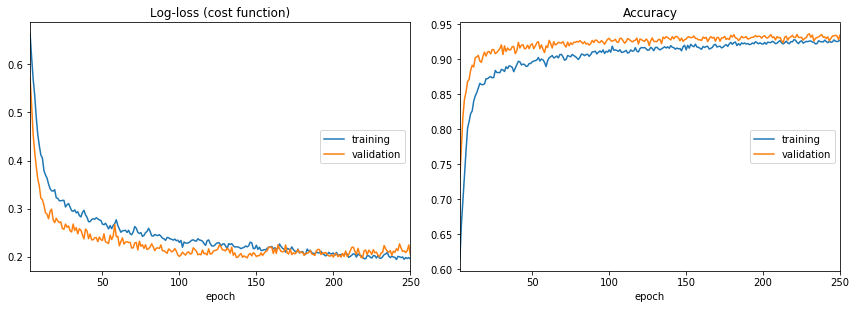

Log-loss (cost function):
training   (min:    0.194, max:    0.806, cur:    0.196)
validation (min:    0.197, max:    0.661, cur:    0.205)

Accuracy:
training   (min:    0.553, max:    0.928, cur:    0.927)
validation (min:    0.599, max:    0.936, cur:    0.935)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1500)              180000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1500)              6000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               750500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________

In [169]:
#Keras Callbacks
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                               min_delta=0,
#                                               patience=50,
#                                               verbose=1,
#                                               mode='auto')


from keras.utils import multi_gpu_model
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
from keras.utils import multi_gpu_model
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain
from livelossplot import PlotLossesKeras

MCP = keras.callbacks.ModelCheckpoint(
   "models\\LendingClub_v2\\ann_deepexplain.h5",
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True)

model = Sequential()
model.add(Dense(1500, input_shape = (119,), activation = 'relu'))
model.add(BatchNormalization(momentum = .62))
model.add(Dropout(0.75))
model.add(Dense(500, activation = 'relu'))
model.add(BatchNormalization(momentum = .62))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

with tf.device('/gpu:0'):
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                        log_device_placement=True))

    history = model.fit(encoded_train.toarray(), tf.keras.utils.to_categorical(y_train,2), batch_size= 1000,
                   epochs=250, verbose=2,\
                        validation_split= .2, callbacks= [MCP, PlotLossesKeras()])
    sess.close()

model.summary()

In [170]:
path_to_ann = 'models\\LendingClub_v2\\ann_deepexplain.h5'


In [171]:
model = load_model(path_to_ann)

 Neural Net Classification Report...
 
0.93175
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2000
           1       0.89      0.98      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000



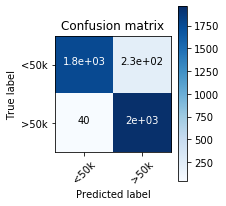

array([[1767,  233],
       [  40, 1960]], dtype=int64)

In [172]:
#Some classification Reports and Confusion Matrices
ypred = np.argmax(model.predict(encoder.transform(X_test).toarray()), axis = 1)
ytest = y_test
class_names = ['<50k', '>50k']
rcParams['figure.figsize'] = 3, 3
print("\033[1m Neural Net Classification Report...\n \033[0m")
print(sklearn.metrics.accuracy_score(ytest,ypred))
print(sklearn.metrics.classification_report(ytest, ypred))
cm = sklearn.metrics.confusion_matrix(ytest, ypred)
plot_confusion_matrix(cm, classes=class_names)
plt.show()
cm